# Introduction

This notebook will illustrate experiments with the Adam optimizer in TensorFlow to solve the `pde_02` 2-D PDE BVP.

## The `pde_02` PDE problem

This PDE was created as a sanity check for the code. The differential equation is provided in the form:

\begin{equation}
    \nabla^2 \psi (x,y) = 2 x
\end{equation}

or:

\begin{equation}
    G \left( x, y, \psi, \frac {\partial \psi} {dx}, \frac {\partial \psi} {\partial y}, \frac {\partial^2 \psi} {dx^2}, \frac {\partial^2 \psi} {\partial y^2} \right) = \frac {\partial^2 \psi} {\partial x^2} + \frac {\partial^2 \psi} {dy^2} - 2 x = 0
\end{equation}

with boundary conditions:

\begin{equation}
    f_0(0, y) = \psi(0, y) = 0 \\
    f_1(1, y) = \psi(1, y) = y^2 \\
    g_0(x, 0) = \psi(x, 0) = 0 \\
    g_1(x, 1) = \psi(x, 1) = x \\
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x, y) = x y^2
\end{equation}

The derivatives are:

\begin{equation}
    \frac {\partial \psi} {\partial x} = y^2 \\
    \frac {\partial \psi} {\partial y} = 2 x y \\
    \frac {\partial^2 \psi} {\partial x^2} = 0 \\
    \frac {\partial^2 \psi} {\partial y^2} = 2 x
\end{equation}

The analytical solution in the domain $0 \leq x,y \leq 1$ is plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
from math import exp
import os
import platform
import sys

# Import 3rd-party modules.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Import TensorFlow.
import tensorflow as tf

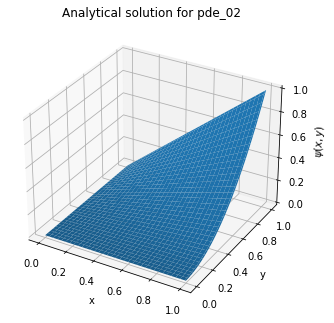

In [2]:
# Import the problem definition.
eq_name = "pde_02"
eq_module = 'nnde.differentialequation.examples.pde_02'
eq = importlib.import_module(eq_module)

# Compute the analytical solution.
# Note that Y is used in place of \psi in the code.
na = 101
xa = np.linspace(0, 1, na)
ya = np.linspace(0, 1, na)
Ya = [[eq.Ya([x, y]) for x in xa] for y in ya]
Ya = np.array(Ya)

# Plot the analytical solution.
fig = plt.figure()
(X, Y) = np.meshgrid(xa, ya)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Ya)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi(x,y)$')
plt.title("Analytical solution for %s" % eq_name)
plt.show()

## Solving `pde_02` using TensorFlow

In [3]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [4]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [5]:
from nnde.math.trainingdata import create_training_grid2

def create_training_data(*n_train):
    x_train = np.array(create_training_grid2(*n_train))
    return x_train

In [6]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [7]:
print_system_information()

System report:
2021-10-02 15:11:09.156272
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Mon Aug 30 06:12:21 PDT 2021; root:xnu-7195.141.6~3/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
Python build: ('default', 'Aug  6 2021 08:56:27')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [8]:
# Define the hyperparameters.

# Set up the output directory.
path = "./pde_02_tf_adam"
output_dir = create_output_directory(path)

# Training optimizer
training_algorithm = "Adam"

# Initial parameter ranges
w0_range = [-0.1, 0.1]
u0_range = [-0.1, 0.1]
v0_range = [-0.1, 0.1]

# Number of hidden nodes.
H = 10

# Number of training points in each dimension.
nx_train = 11
ny_train = 11
n_train = nx_train*ny_train

# Number of training epochs.
n_epochs = 1000

# Learning rate.
learning_rate = 0.01

# Random number generator seed.
random_seed = 0

In [9]:
# Create and save the training data.
xy_train = create_training_data(nx_train, ny_train)
x_train = xy_train[::ny_train, 0]
y_train = xy_train[:nx_train, 1]
np.savetxt(os.path.join(output_dir,'xy_train.dat'), xy_train)

In [10]:
# Build the model.
model = build_model(H, w0_range, u0_range, v0_range)

# Create the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

2021-10-02 15:11:09.441153: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Train the model.

# Create history variables.
losses = []
phist = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Rename the training data Variable (_v) for convenience, just for training.
xy_train_v = tf.Variable(xy_train, dtype=tf.float32, name="xy_train")
xy = xy_train_v

print("Hyperparameters: n_train = %s, H = %s, n_epochs = %s, learning_rate = %s"
      % (n_train, H, n_epochs, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(n_epochs):

    # Run the forward pass.
    with tf.GradientTape() as tape3:
        with tf.GradientTape(persistent=True) as tape2:
            with tf.GradientTape() as tape1:

                # Compute the network output.
                N = model(xy)

                # Compute the trial solution.
                A = xy[:, 0] + xy[:, 1]**2
                Y = A + xy[:, 0]*(1 - xy[:, 0])*xy[:, 1]*(1 - xy[:, 1])*N[:, 0]

            # Compute the gradient of the trial solution wrt inputs.
            dY_dxy = tape1.gradient(Y, xy)
            dY_dx = dY_dxy[:, 0]
            dY_dy = dY_dxy[:, 1]

        # Compute the Laplacian components of the trial solution gradient wrt inputs.
        d2Y_dx2 = tape2.gradient(dY_dx, xy)[:, 0]
        d2Y_dy2 = tape2.gradient(dY_dy, xy)[:, 1]

        # Compute the estimates of the differential equations.
        G = d2Y_dx2 + d2Y_dy2 - 2*xy[:, 0]

        # Compute the loss function.
        L = tf.math.sqrt(tf.reduce_sum(G**2)/n_train)

    # Save the current losses.
    losses.append(L.numpy())

    # Compute the gradient of the loss function wrt the network parameters.
    pgrad = tape3.gradient(L, model.trainable_variables)

    # Save the parameters used in this pass.
    phist.append(
        np.hstack(
            (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
             model.trainable_variables[1].numpy(),       # u (H,) row vector
             model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this pass.
    optimizer.apply_gradients(zip(pgrad, model.trainable_variables))

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())

# Save the parameter histories.
np.savetxt(os.path.join(output_dir, 'phist.dat'), np.array(phist))

Hyperparameters: n_train = 121, H = 10, n_epochs = 1000, learning_rate = 0.01
Training started at 2021-10-02 15:11:09.455082
Training stopped at 2021-10-02 15:11:27.248877
Total training time was 17.793795 seconds.


In [12]:
# Compute and save the trained results at training points.
with tf.GradientTape(persistent=True) as tape2:
    with tf.GradientTape(persistent=True) as tape1:
        N = model(xy)
        A = xy[:, 0] + xy[:, 1]**2
        Yt_train = A + xy[:, 0]*(1 - xy[:, 0])*xy[:, 1]*(1 - xy[:, 1])*N[:, 0]
    dYt_dx_train = tape1.gradient(Yt_train, xy)
d2Yt_dx2_train = tape2.gradient(dYt_dx_train, xy)
np.savetxt(os.path.join(output_dir, 'Yt_train.dat'), Yt_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'dYt_dx_train.dat'), dYt_dx_train[:, 0].numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'dYt_dy_train.dat'), dYt_dx_train[:, 1].numpy().reshape((n_train)))

# Compute and save the analytical solution and derivative at training points.
Ya_train = np.array([eq.Ya(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'Ya_train.dat'), Ya_train)
dYa_dx_train = np.array([eq.dYa_dx(xy) for xy in xy_train])
dYa_dy_train = np.array([eq.dYa_dy(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'dYa_dx_train.dat'), dYa_dx_train)
np.savetxt(os.path.join(output_dir,'dYa_dy_train.dat'), dYa_dy_train)
d2Ya_dx2_train = np.array([eq.d2Ya_dx2(xy) for xy in xy_train])
d2Ya_dy2_train = np.array([eq.d2Ya_dy2(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'d2Ya_dx2_train.dat'), d2Ya_dx2_train)
np.savetxt(os.path.join(output_dir,'d2Ya_dy2_train.dat'), d2Ya_dy2_train)

# Compute and save the error in the trained solution and derivatives at training points.
Yt_err_train = Yt_train.numpy().reshape((n_train)) - Ya_train
np.savetxt(os.path.join(output_dir, 'Yt_err_train.dat'), Yt_err_train)
dYt_dx_err_train = dYt_dx_train[:, 0].numpy().reshape((n_train)) - dYa_dx_train
dYt_dy_err_train = dYt_dx_train[:, 1].numpy().reshape((n_train)) - dYa_dy_train
np.savetxt(os.path.join(output_dir, 'dYt_dx_err_train.dat'), dYt_dx_err_train)
np.savetxt(os.path.join(output_dir, 'dYt_dy_err_train.dat'), dYt_dy_err_train)
d2Yt_dx2_err_train = d2Yt_dx2_train[:, 0].numpy().reshape((n_train)) - d2Ya_dx2_train
d2Yt_dy2_err_train = d2Yt_dx2_train[:, 1].numpy().reshape((n_train)) - d2Ya_dy2_train
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_err_train.dat'), d2Yt_dx2_err_train)
np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_err_train.dat'), d2Yt_dy2_err_train)

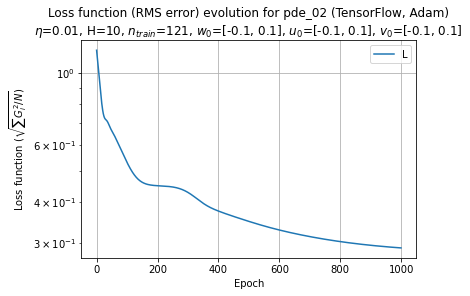

In [13]:
# Plot the loss function history.
plt.semilogy(losses, label="L")
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.legend()
plt.title("Loss function (RMS error) evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.show()

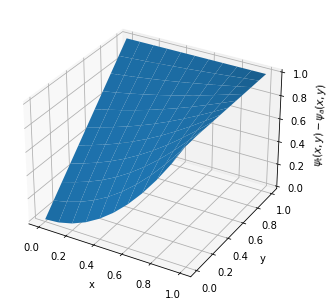

In [16]:
# Plot the error in the trained solution at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
Z = Yt_err_train.reshape((nx_train, ny_train))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi_t(x,y)-\psi_a(x,y)$')
plt.show()

# WHY IS ERROR EXACTLY 1.0 AT (x,y) = (1,y)? THAT IS SUSPICIOUS.

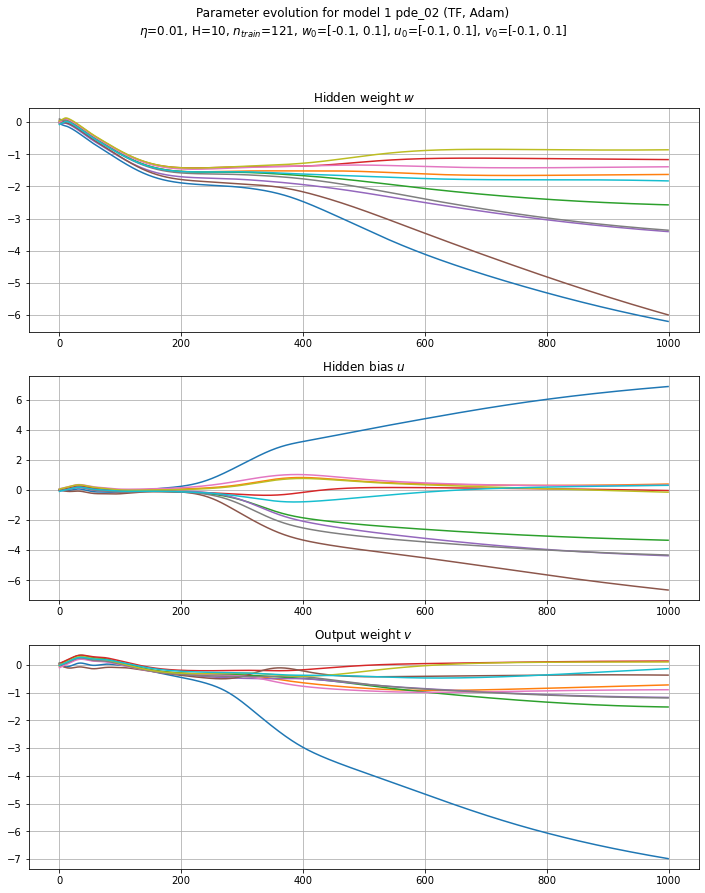

In [15]:
# Plot the parameter histories.
phist = np.array(phist)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for model 1 %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TF', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.subplots_adjust(hspace=0.2)
plt.show()